/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/aggregation_functions.py:118: RuntimeWarning: Mean of empty slice
  return np.nanmean(X, axis=1)
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:680: UserWarning: WARNING: Alpha should not be specified in the prediction method
with conformalized quantile regression.
  warnings.warn(
/Users/paulsilberbauer/PycharmProjects/Bachelorarbeit/.venv/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


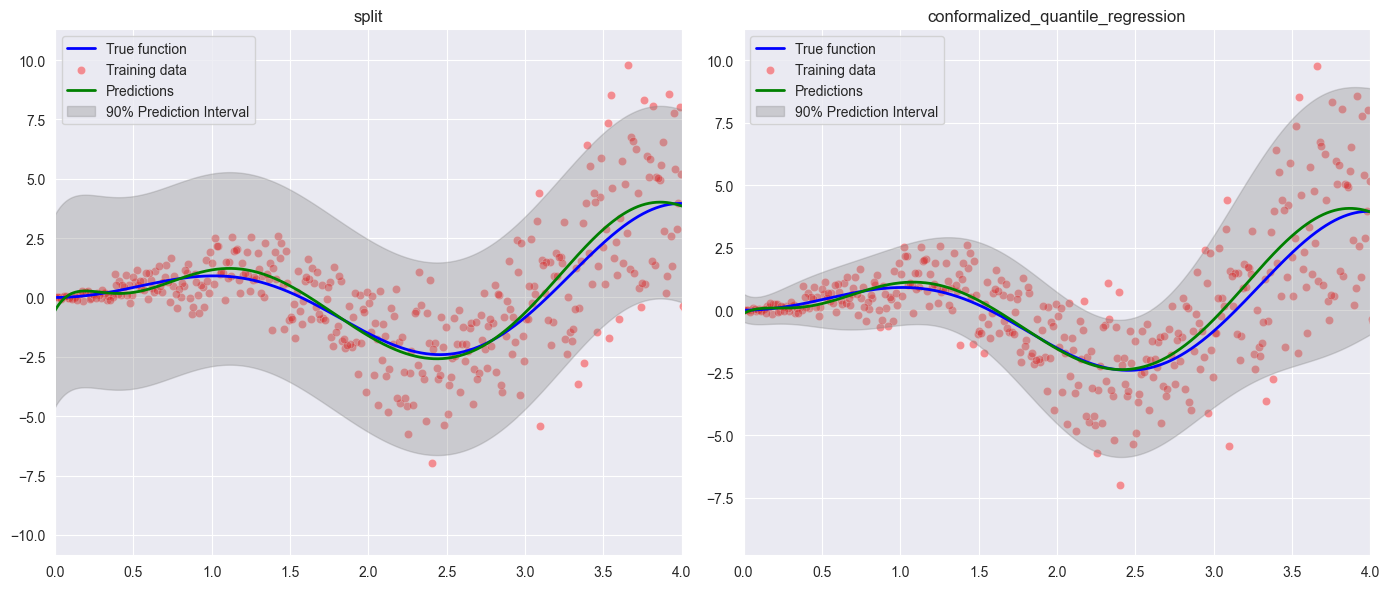

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, QuantileRegressor
from mapie.regression import MapieRegressor, MapieQuantileRegressor


def x_sinx(x):
    return x * np.sin(2 * x)


def get_1d_data_with_heteroscedastic_noise(funct, min_x, max_x, n_samples, noise):
    np.random.seed(59)
    X_train = np.linspace(min_x, max_x, n_samples)
    np.random.shuffle(X_train)
    X_test = np.linspace(min_x, max_x, n_samples * 5)
    y_train = funct(X_train) + (np.random.normal(0, noise, len(X_train)) * X_train)
    y_test = funct(X_test) + (np.random.normal(0, noise, len(X_test)) * X_test)
    y_mesh = funct(X_test)
    return X_train.reshape(-1, 1), y_train, X_test.reshape(-1, 1), y_test, y_mesh

min_x, max_x, n_samples, noise = 0, 5, 500, 0.7
X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_heteroscedastic_noise(
    x_sinx, min_x, max_x, n_samples, noise
)


degree_polyn = 10
polyn_model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree_polyn)),
    ("linear", LinearRegression())
])
polyn_model_quant = Pipeline([
    ("poly", PolynomialFeatures(degree=degree_polyn)),
    ("linear", QuantileRegressor(solver="highs", alpha=0))
])

# Setting strategies for Mapie
STRATEGIES = {
    "split": {"method": "base", "cv": "split"},
    "conformalized_quantile_regression": {"method": "quantile", "cv": "split", "alpha": 0.1}
}

# Fitting models and predicting
results = {}
for strategy, params in STRATEGIES.items():
    if strategy == "conformalized_quantile_regression":
        mapie = MapieQuantileRegressor(polyn_model_quant, **params)
    else:
        mapie = MapieRegressor(polyn_model, **params)
    mapie.fit(X_train, y_train)
    y_pred, y_pis = mapie.predict(X_test, alpha=0.1)
    results[strategy] = (y_pred, y_pis)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, (strategy, (y_pred, y_pis)) in zip(axes, results.items()):
    sns.lineplot(x=X_test.ravel(), y=y_mesh, ax=ax, label='True function', color='blue', linewidth=2)
    sns.scatterplot(x=X_train.ravel(), y=y_train, ax=ax, color='red', alpha=0.4, label='Training data')
    sns.lineplot(x=X_test.ravel(), y=y_pred.ravel(), ax=ax, color='green', label='Predictions', linewidth=2)
    ax.fill_between(X_test.ravel(), y_pis[:, 0, 0], y_pis[:, 1, 0], color='grey', alpha=0.3, label='90% Prediction Interval')
    ax.set_xlim([0, 4])
    ax.set_title(f"{strategy}")
    ax.legend()

plt.tight_layout()
plt.show()
